In [1]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

c:\Users\mahim\Documents\GENAI\PEFT_Fine_Tuning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [3]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params:,}\nall model parameters: {all_model_params:,}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247,577,856
all model parameters: 247,577,856
percentage of trainable model parameters: 100.00%


#### Test the Model with Zero Shot Inferencing

In [5]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

In [6]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    
    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])


tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter: 100%|██████████| 1500/1500 [00:03<00:00, 416.68 examples/s]


#### Setup the PEFT/LoRA model for Fine-Tuning



In [7]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

In [8]:
peft_model = get_peft_model(original_model, lora_config) 
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3,538,944
all model parameters: 251,116,800
percentage of trainable model parameters: 1.41%


In [9]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3,
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1    
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

In [10]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

100%|██████████| 1/1 [1:13:56<00:00, 4436.22s/it]


{'loss': 48.0, 'grad_norm': 9.195874214172363, 'learning_rate': 0.0, 'epoch': 0.06}
{'train_runtime': 4436.2232, 'train_samples_per_second': 0.002, 'train_steps_per_second': 0.0, 'train_loss': 48.0, 'epoch': 0.06}


('./peft-dialogue-summary-checkpoint-local\\tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local\\special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local\\tokenizer.json')

In [11]:
from peft import PeftModel, PeftConfig

peft_dialogue_summary_checkpoint = peft_model_path

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       peft_dialogue_summary_checkpoint, 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

c:\Users\mahim\Documents\GENAI\PEFT_Fine_Tuning\.venv\Lib\site-packages\peft\peft_model.py:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


In [12]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251,116,800
percentage of trainable model parameters: 0.00%


In [14]:
instruct_model_name="truocpham/flan-dialogue-summary-checkpoint"

instruct_model = AutoModelForSeq2SeqLM.from_pretrained( instruct_model_name, torch_dtype=torch.bfloat16)

In [16]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: Have you considered upgrading your system?
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person1#: I'm thinking of upgrading my computer.


In [17]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]
    
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,This memo should go out to all employees by th...,#Person1# asks Ms. Dawson to take a dictation ...,The memo is to be distributed to all employees...
1,In order to prevent employees from wasting tim...,This memo is to be distributed as a memo to al...,#Person1# asks Ms. Dawson to take a dictation ...,The memo is to be distributed to all employees...
2,Ms. Dawson takes a dictation for #Person1# abo...,The Office of the President and CEO is request...,#Person1# asks Ms. Dawson to take a dictation ...,The memo is to be distributed to all employees...
3,#Person2# arrives late because of traffic jam....,#Person1#: I got stuck in traffic. #Person2#: ...,#Person2# got stuck in traffic again. #Person1...,The traffic jam at the Carrefour intersection ...
4,#Person2# decides to follow #Person1#'s sugges...,People are deciding whether to take public tra...,#Person2# got stuck in traffic again. #Person1...,The traffic jam at the Carrefour intersection ...
5,#Person2# complains to #Person1# about the tra...,The driver of the car is stuck in traffic.,#Person2# got stuck in traffic again. #Person1...,The traffic jam at the Carrefour intersection ...
6,#Person1# tells Kate that Masha and Hero get d...,#Person1: Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Masha and Hero are getting divorced.
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Masha and Hero are getting divorced.
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are divorced.,Masha and Hero are getting divorced. Kate can'...,Masha and Hero are getting divorced.
9,#Person1# and Brian are at the birthday party ...,Brian's birthday is tomorrow.,Brian's birthday is coming. #Person1# invites ...,Brian's birthday is coming up.


In [18]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

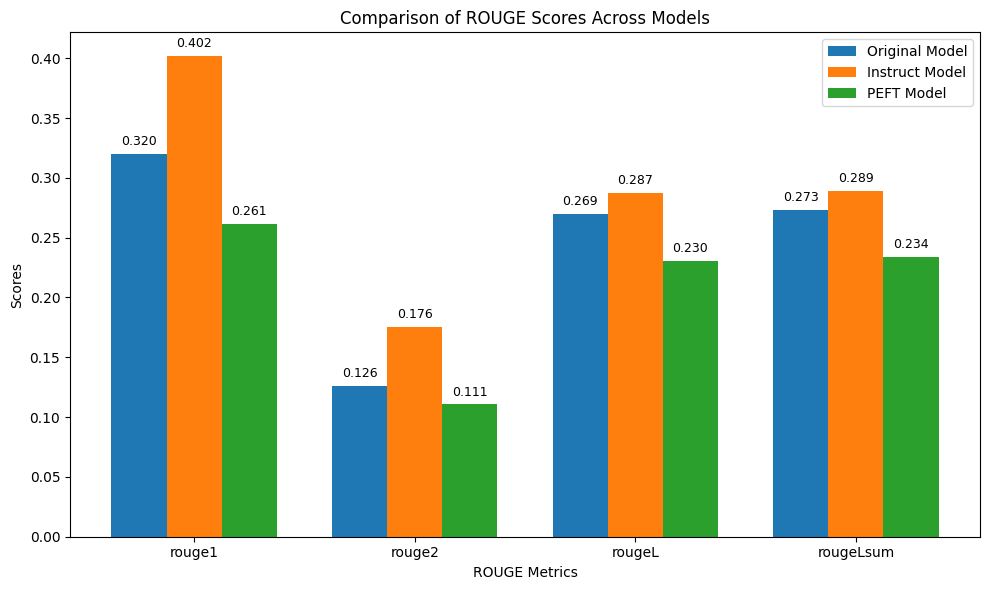

In [19]:
# Use the original variables from the image
results = {
    "Original Model": {
        "rouge1": original_model_results["rouge1"],
        "rouge2": original_model_results["rouge2"],
        "rougeL": original_model_results["rougeL"],
        "rougeLsum": original_model_results["rougeLsum"],
    },
    "Instruct Model": {
        "rouge1": instruct_model_results["rouge1"],
        "rouge2": instruct_model_results["rouge2"],
        "rougeL": instruct_model_results["rougeL"],
        "rougeLsum": instruct_model_results["rougeLsum"],
    },
    "PEFT Model": {
        "rouge1": peft_model_results["rouge1"],
        "rouge2": peft_model_results["rouge2"],
        "rougeL": peft_model_results["rougeL"],
        "rougeLsum": peft_model_results["rougeLsum"],
    },
}

# Extract metrics and models
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
models = list(results.keys())
data = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plot bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [data[metric][i] for metric in metrics], width, label=model)
    
    # Add numbers above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005,  # Positioning slightly above the bar
            f'{height:.3f}', 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Add labels and titles
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of ROUGE Scores Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -14.05%
rouge2: -6.51%
rougeL: -5.72%
rougeLsum: -5.47%
